# Garbage Classification using PyTorch

Import the libraries

In [1]:
#1.8.1     0.9.1
import os
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


구글 드라이브 마운트 & class 확인:

In [2]:
data_dir  = 'dataset/'

classes = os.listdir(data_dir)
print(classes)
print(len(classes))

['cd', 'Disposable chopsticks', 'PET', '건전지', '계란판', '고무장갑', '드라이버', '마스크', '상자', '스파우트파우치', '스프링노트', '아이스팩', '알약', '영수증', '요구르트병', '유리', '은박보냉백', '종이', '종이팩', '칫솔', '캔', '플라스틱', '플라스틱통', '헤어드라이어']
24


## Transformations:

Dataset 불러오고 변환 후 저장


In [3]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

transformations = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

dataset = ImageFolder(data_dir, transform = transformations)

dataset이 잘 불러와졌는지 확인

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

def imshow_denormalize(img):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)

def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    imshow_denormalize(img)

Label: PET (Class No: 1)


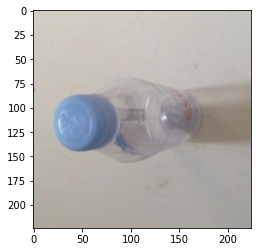

In [5]:
img, label = dataset[1000]
show_sample(img, label)

# Loading and Splitting Data:

In [6]:
random_seed = 42
torch.manual_seed(random_seed)

dataset을 training, validation, test set로 나눔


( ratio = train:80% , validation:10%, test:10% )

In [7]:
test_len = int(len(dataset) * 0.1)
train_len = len(dataset) - test_len
validation_len = int(train_len * (1/9))
train_ds, val_ds, test_ds = random_split(dataset, [train_len-validation_len, validation_len, test_len])
len(train_ds), len(val_ds), len(test_ds)

(10399, 1299, 1299)

DataLoader를 이용하여 train, validation 데이터 셋을 batch_size (=32) 만큼씩 나눔

In [8]:
from torch.utils.data.dataloader import DataLoader
batch_size = 16

train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 2, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 2, pin_memory = True)

Batch가 잘 나눠졌는지 확인하기 위해 시각화


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


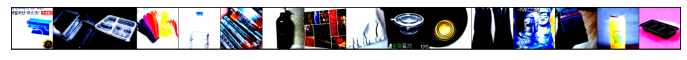

In [9]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

show_batch(train_dl)

# Model Base:

In [10]:
# 정확도 계산 (top-1)
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

##self.backbone = models.resnet50(pretrained=True) 수정



- resnet18 = models.resnet18(pretrained=True)
- alexnet = models.alexnet(pretrained=True)
- squeezenet = models.squeezenet1_0(pretrained=True)
- vgg16 = models.vgg16(pretrained=True)
- densenet = models.densenet161(pretrained=True)
- inception = models.inception_v3(pretrained=True)
- googlenet = models.googlenet(pretrained=True)
- shufflenet = models.shufflenet_v2_x1_0(pretrained=True)
- mobilenet_v2 = models.mobilenet_v2(pretrained=True)
- mobilenet_v3_large = models.mobilenet_v3_large(pretrained=True)
- mobilenet_v3_small = models.mobilenet_v3_small(pretrained=True)
- resnext50_32x4d = models.resnext50_32x4d(pretrained=True)
- wide_resnet50_2 = models.wide_resnet50_2(pretrained=True)
- mnasnet = models.mnasnet1_0(pretrained=True)

Reference : https://pytorch.org/vision/stable/models.html

In [11]:
class OurModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.backbone = models.resnext50_32x4d(pretrained=True)
        # Replace last layer
        num_ftrs = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(num_ftrs, len(dataset.classes))
    
    def forward(self, xb):
        return torch.softmax(self.backbone(xb), dim=1)

    def get_loss(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
model = OurModel()

## Porting to GPU:

GPUs tend to perform faster calculations than CPU. Let's take this advantage and use GPU for computation:

In [70]:
def list_to_device(batch, device):
    converted_batch = []
    for data in batch:
        converted_batch.append(data.to(device, non_blocking=True))
    return converted_batch

In [71]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device
torch.cuda.empty_cache()

In [72]:
model.to(device)

OurModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Seq

# Training the Model:

This is the function for fitting the model.

In [76]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval() # eval 모드로 전환
    outputs = [model.validation(list_to_device(batch,device)) for batch in val_loader] # 각 batch별 loss, acc 저장
    
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.get_loss(list_to_device(batch, device))
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        print(f"Epoch {epoch+1}: train_loss: {result['train_loss']:.4f}, val_loss: {result['val_loss']:.4f}, val_acc: {result['val_acc']:.4f}"
        history.append(result)
    return history

In [74]:
model = OurModel().to(device)

In [75]:
evaluate(model, val_dl)

{'val_loss': 3.1815929412841797, 'val_acc': 0.023628048598766327}

Let's start training the model:

In [18]:
num_epochs = 8
opt_func = torch.optim.Adam
lr = 5.5e-5

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch 1: train_loss: 2.5903, val_loss: 2.3907, val_acc: 0.8679
Epoch 2: train_loss: 2.3655, val_loss: 2.3146, val_acc: 0.9375
Epoch 3: train_loss: 2.3087, val_loss: 2.3036, val_acc: 0.9489
Epoch 4: train_loss: 2.2921, val_loss: 2.2974, val_acc: 0.9573
Epoch 5: train_loss: 2.2819, val_loss: 2.3005, val_acc: 0.9505
Epoch 6: train_loss: 2.2775, val_loss: 2.2945, val_acc: 0.9588
Epoch 7: train_loss: 2.2706, val_loss: 2.3001, val_acc: 0.9484
Epoch 8: train_loss: 2.2735, val_loss: 2.2935, val_acc: 0.9566


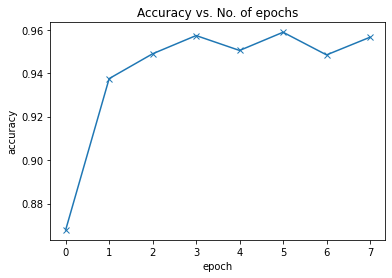

In [19]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

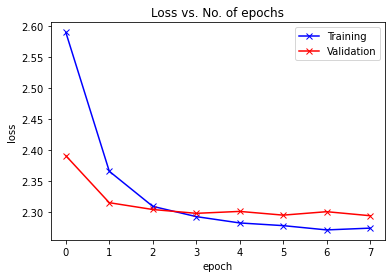

In [20]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

#Saving the model

In [24]:
Path = ''
FileName = 'resnext50_32x4d.pt'
torch.save(model, Path+FileName)

# Visualizing Predictions:
Test set에 있는 이미지들 예측 결과입니다.

In [25]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

In [26]:
'''
for i in range(10):
  img, label = test_ds[i]
  print('i:', i, 'Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))
'''

"\nfor i in range(10):\n  img, label = test_ds[i]\n  print('i:', i, 'Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))\n"

Label: 요구르트병 , Predicted: 요구르트병


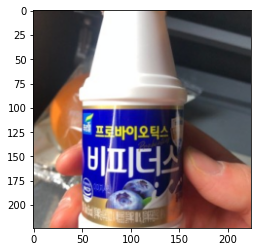

In [27]:
img, label = test_ds[102]
#plt.imshow(img.permute(1, 2, 0))
imshow_denormalize(img)
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

# 직접 찍은 사진들로 테스트한 결과입니다.

savedModels 디렉토리에 저장된 모델을 가져옵니다.
- loaded_model = model : 위에서 학습한 모델 사용
- loaded_model = torch.load('~/modelname.pt') : 모델 불러오기 
- model.eval() : 모델의 모드를 evaluation 모드로 바꿉니다. (prediction을 위해)

Ref : https://tutorials.pytorch.kr/beginner/saving_loading_models.html

In [28]:
loaded_model = model

#drive.mount('/content/drive')
'''
loaded_model = OurModel()
Path = '/content/drive/MyDrive/캡디/savedModels/'
FileName = 'resnext50_32x4d.pt'
loaded_model = torch.load(Path+FileName)
'''
model.eval()

OurModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Seq

This function takes the image's name and prints the predictions:

In [29]:
from PIL import Image
from pathlib import Path

def predict_external_image(image_name):
    #image = Image.open(Path('/content/drive/MyDrive/test/' + image_name))
    image = Image.open(Path('/content/drive/MyDrive/캡디/test/' + image_name))
    example_image = transformations(image)
    #plt.imshow(example_image.permute(1, 2, 0))
    imshow_denormalize(example_image)
    print("이 물건은 ", predict_image(example_image, loaded_model) + "입니다.")

In [30]:
predict_external_image('test_cd2.jpg')

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\content\\drive\\MyDrive\\캡디\\test\\test_cd2.jpg'

In [ ]:
predict_external_image('test_tooth brush.jpg')

In [ ]:
predict_external_image('test_rubber glove.jpg')

In [ ]:
predict_external_image('test_hairdryer.jpg')

In [ ]:
predict_external_image('test_egg1.jpg')

In [ ]:
predict_external_image('test_PET.jpg')

In [ ]:
predict_external_image('test_yogurt.jpg')

In [ ]:
predict_external_image('test_sd1.jpg')

In [ ]:
predict_external_image('test_sd2.jpg')

In [ ]:
predict_external_image('test_mask1.jpg')

In [ ]:
predict_external_image('test_mask2.jpg')

In [ ]:
predict_external_image('test_notebook1.jpg')

In [ ]:
predict_external_image('test_notebook3.jpg')

In [ ]:
predict_external_image('test_icepack2.jpg')

In [ ]:
predict_external_image('test_receipt1.jpg')

In [ ]:
predict_external_image('test_receipt2.jpg')

In [ ]:
predict_external_image('test_receipt3.jpg')

In [ ]:
predict_external_image('test_receipt4.jpg')

In [ ]:
predict_external_image('test_pill1.jpg')

In [ ]:
predict_external_image('test_pill2.jpg') # 2 class가 한 이미지에 있을 때.  0.6874

#Convert PyTorch models to Core ML

https://developer.apple.com/videos/play/tech-talks/10154/

In [ ]:
!pip install -U coremltools
import coremltools as ct

In [ ]:
sample_img = dataset[0][0]
sample_img = to_device(sample_img.unsqueeze(0), device)

In [ ]:
traced_model = torch.jit.trace(loaded_model, sample_img)
_input = ct.ImageType(
    name = "InputImg",
    shape = sample_img.shape,
    bias = [-0.485/0.229, -0.456/0.224, -0.406/0.225],
    scale = 1./(255*0.226)
)
#    
print(sample_img.shape)
print(dataset.classes)
classifier_config = ct.ClassifierConfig(dataset.classes)

In [ ]:
mlmodel = ct.convert(
    traced_model,
    inputs= [_input],
    classifier_config=classifier_config
)

mlmodel.short_description = "Trash Image Classifier"
mlmodel.save("/content/drive/MyDrive/캡디/TrashClassificationModel.mlmodel")

저장...